# Salary Predictions Based on Job Descriptions

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Author info
__author__ = "Albert Ntiri"
__email__ = "albert.ntiri@gmail.com"

In [2]:
# Read data into pandas dataframes
train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')
test_features = pd.read_csv('data/test_features.csv')

# Combine train_features and train_salaries into 1 dataframe for the training data
training_combined = pd.merge(train_features, train_salaries, how='inner', on='jobId')

## Define Classes

In [3]:
class process_data():
    '''
    This class is for cleaning data and preparing it for modeling.
    
    Attributes:
        data (dataframe): The pandas dataframe supplied when initiating a process_data object.
    '''
    
    def __init__(self, data):
        '''This method is the constructor for the process_data class.'''
        self.data = data
    
    # Drop rows for 0-salary jobs
    def clean_data(self):
        '''This method drops rows for 0-salary jobs.'''
        self.data.drop(index = self.data[self.data.salary == 0].index, axis = 0, inplace = True)
    
    # Convert categorical variables to numeric based on hierarchy
    def label_encode(self, col, new_col, map_dict):
        '''This method converts categorical variables to numeric based on hierarchy, defined by the map_dict parameter.'''
        self.data[new_col] = self.data[col].map(map_dict)
    
    # Convert non-hierarchical categorical variables to dummy variables
    def one_hot_encode(self, col, drop_first=False):
        '''This method converts non-hierarchical categorical variables to dummy variables.'''
        self.data = pd.get_dummies(self.data, columns=[col], drop_first=drop_first)
        
    # Drop single or list of columns
    def drop_columns(self, col):
        '''This method drops a single or a list of columns.'''
        self.data.drop(col, axis=1, inplace=True)
    
    # Use function to convert old values in column to new values in new column
    def transform(self, col, new_col, function):
        '''This method uses a function to convert the values in an existing column to new values in a new column.'''
        self.data[new_col] = self.data[col].apply(function)
    
    # Create indicator value
    def convert_to_bool(self, string):
        '''This method creates an indicator value from a string.'''
        if string == 'NONE':
            return 0
        else:
            return 1
    
    # Scale numeric variables to 0-1 range
    def normalize(self, col, new_col):
        '''This method scales numeric variables to 0-1 range.'''
        self.data[new_col] = preprocessing.Normalizer(norm='max').transform([self.data[col]])[0]

In [4]:
class model():
    '''
    This class is for building a model, training it, and using it to make predictions.
    
    Attributes:
        model_type: The type of model used to make predictions.  This is provided when instantiating the object.
        data (dataframe): The pandas dataframe used to train the model and use it for predictions.
        features (list): The variables used by the model to make predictions.
        target: The value the model aims to predict.
        model: The model after it has been fitted to the training data.
        cv_score: The mean squared error when using cross validation on the production model.
    '''
    
    def __init__(self, model_type, data, features, target):
        '''This method is the constructor for the model class.'''
        self.model_type = model_type
        self.data = data
        self.features = features
        self.target = target
        self.cv_score = 0
    
    def build_model(self, model_name, compare_df, test_size=.2):
        '''This method splits the dataframe into training and test sets, trains the model on the training data, 
        makes predictions on the test set, and saves metrics in the compare_df dataframe.'''
        
        # Split data set into training and test sets based on the test_size parameter
        features_train, features_test, target_train, target_test = train_test_split(self.data[self.features], self.data[self.target], test_size=test_size)
        
        # Fit the model to the training data and save the score as a variable
        model = self.model_type.fit(features_train, target_train)
        training_r2 = model.score(features_train, target_train)
        self.model = model
        
        # Make predictions on the test set and save the R^2 and MSE scores as variables
        predicted_target = model.predict(features_test)
        test_r2 = r2_score(y_true=target_test, y_pred=predicted_target)
        mse = mean_squared_error(y_true=target_test, y_pred=predicted_target)
        
        # Add the 3 scores to the compare_df (given as an argument)
        compare_df.loc[model_name] = [training_r2, test_r2, mse]
        
        return model
    
    # Run cross validation on model
    def cross_validate(self, cv, scoring='neg_mean_squared_error'):
        '''This method runs cross validation on the dataset.'''
        neg_mse = cross_val_score(self.model, self.data[self.features], self.data[self.target],  cv=cv, scoring=scoring)
        avg_mse = sum(neg_mse) / len(neg_mse) * -1.0
        print(avg_mse)
        self.cv_score = avg_mse
    
    # Make predictions on given data set
    def predict(self, data):
        '''This method makes predictions on the given dataset.'''
        predictions = self.model.predict(data)
        return predictions

In [5]:
class compare():
    '''
    This class is for comparing the results of different models.
    
    Attributes:
        data (dataframe): The pandas dataframe supplied when initiating a compare object.
    '''
    
    def __init__(self, df):
        '''This method is the constructor for the compare class.'''
        self.data = df
    
    # Create a bar graph of given column of dataframe and save it as a jpg file
    def graph_results(self, col, name):
        '''This method creates a bar graph of a given column of the dataframe and saves it as a jpg file.'''
        metric_compare = self.data[col].sort_values()
        graph_title = col.replace('_',' ')
        file_name = 'charts/model_comparison_{}.jpg'.format(name)
        
        fig, ax = plt.subplots(figsize=(7,4))
        fig.subplots_adjust(left=.4)
        ax.barh(metric_compare.index, metric_compare)
        
        ax.set_title(graph_title)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.savefig(file_name)

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [6]:
# Instantiate an object for the process_data class (defined above) for the training data
training_data = process_data(training_combined)

# Remove 0-salary jobs from the training data
training_data.clean_data()

# Use the following dictionary to convert the jobType column into a new numeric feature (ranked by average salary)
# CFO and CTO have the same numeric value because their average salaries in the training data are very similar
job_levels = {
    'JANITOR': 1,
    'JUNIOR': 2,
    'SENIOR': 3,
    'MANAGER': 4,
    'VICE_PRESIDENT': 5,
    'CFO': 6,
    'CTO': 6,
    'CEO': 7
}
training_data.label_encode('jobType', 'jobLevel', job_levels)

# Use the following dictionary to convert the degree column into a new numeric feature (ranked by average salary)
degree_levels = {
    'NONE': 0,
    'HIGH_SCHOOL': 1,
    'BACHELORS': 2,
    'MASTERS': 3,
    'DOCTORAL': 4
}
training_data.label_encode('degree', 'degreeLevel', degree_levels)

# Create a new feature called majorInd showing whether there is a major
training_data.transform('major', 'majorInd', training_data.convert_to_bool)

# Create dummy variables out of the unique values of the major column
training_data.one_hot_encode('major')

# Remove the none value for major to use as a control group
training_data.drop_columns('major_NONE')

# Create dummy variables out of the unique values of the industry column, using the first value as a control group
training_data.one_hot_encode('industry', drop_first=True)

# Scale yearsExperience column from 0 - 1 to prevent unbalanced effects on salary
training_data.normalize('yearsExperience', 'yearsExperience_norm')

# Scale milesFromMetropolis column from 0 - 1 to prevent unbalanced effects on salary
training_data.normalize('milesFromMetropolis', 'milesFromMetropolis_norm')

# Remove all the original columns that will not be used for modeling
old_columns = ['jobId', 'companyId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis']
training_data.drop_columns(old_columns)

### ---- 8 Create models ----

In [7]:
# Initialize different models
lin_reg = linear_model.LinearRegression()
lasso_reg = linear_model.Lasso(alpha=.01)
ridge_reg = linear_model.Ridge(alpha=.01)
SGD_reg = linear_model.SGDRegressor(penalty='l1', alpha=.01, max_iter=1000)
GB_reg = GradientBoostingRegressor(n_estimators=500, max_depth=6)

In [8]:
# Set up different features combinations as variables

features1_joblevel = ['jobLevel']
features2_degree = ['degreeLevel']
features3_yearsexperience = ['yearsExperience_norm']
features4_milesfrommetropolis = ['milesFromMetropolis_norm']
features5_industries = ['industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH', 'industry_OIL', 'industry_SERVICE', 'industry_WEB']
features6_majors = ['major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH', 'major_PHYSICS']
features7_majorind = ['majorInd']
features8_nomajorind = features1_joblevel + features2_degree + features3_yearsexperience + features4_milesfrommetropolis + features5_industries + features6_majors
features9_all = features8_nomajorind + features7_majorind

### ---- 9 Test models ----

In [9]:
# Set up model comparison dataframe
feature_compare = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Mean_Squared_Error'])

# Build model for each previously-defined set of features
lreg1 = model(lin_reg, training_data.data, features1_joblevel, 'salary')
lreg1.build_model('lr_joblevel', compare_df=feature_compare)

lreg2 = model(lin_reg, training_data.data, features2_degree, 'salary')
lreg2.build_model('lr_degree', compare_df=feature_compare)

lreg3 = model(lin_reg, training_data.data, features3_yearsexperience, 'salary')
lreg3.build_model('lr_yearsexperience', compare_df=feature_compare)

lreg4 = model(lin_reg, training_data.data, features4_milesfrommetropolis, 'salary')
lreg4.build_model('lr_milesfrommetropolis', compare_df=feature_compare)

lreg5 = model(lin_reg, training_data.data, features5_industries, 'salary')
lreg5.build_model('lr_industries', compare_df=feature_compare)

lreg6 = model(lin_reg, training_data.data, features6_majors, 'salary')
lreg6.build_model('lr_majors', compare_df=feature_compare)

lreg7 = model(lin_reg, training_data.data, features7_majorind, 'salary')
lreg7.build_model('lr_majorind', compare_df=feature_compare)

lreg8 = model(lin_reg, training_data.data, features8_nomajorind, 'salary')
lreg8.build_model('lr_nomajorind', compare_df=feature_compare)

lreg9 = model(lin_reg, training_data.data, features9_all, 'salary')
lreg9.build_model('lr_all', compare_df=feature_compare)

feature_compare

# Using all features yields the best results

,Training_R2,Test_R2,Mean_Squared_Error
lr_joblevel,0.347260,0.347898,977.712128
lr_degree,0.148114,0.144991,1283.297490
lr_yearsexperience,0.140166,0.142513,1279.545693
lr_milesfrommetropolis,0.088700,0.088280,1367.559377
lr_industries,0.088135,0.087387,1360.684685
lr_majors,0.143305,0.143741,1286.528773
lr_majorind,0.137797,0.138630,1289.448040
lr_nomajorind,0.743456,0.741987,386.386463
lr_all,0.743016,0.743743,385.533516


In [10]:
# Set up model comparison dataframe
algorithm_compare = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Mean_Squared_Error'])

# Build model for each previously-set up algorithm
linear = model(lin_reg, training_data.data, features9_all, 'salary')
linear.build_model('Linear_Regression', compare_df=algorithm_compare)

lasso = model(lasso_reg, training_data.data, features9_all, 'salary')
lasso.build_model('Lasso_Regression', compare_df=algorithm_compare)

ridge = model(ridge_reg, training_data.data, features9_all, 'salary')
ridge.build_model('Ridge_Regression', compare_df=algorithm_compare)

sgd = model(SGD_reg, training_data.data, features9_all, 'salary')
sgd.build_model('Stochastic_Gradient_Descent', compare_df=algorithm_compare)

gb = model(GB_reg, training_data.data, features9_all, 'salary')
gb.build_model('Gradient_Boosting', compare_df=algorithm_compare)

algorithm_compare

# Gradient boosting yields the best results

,Training_R2,Test_R2,Mean_Squared_Error
Linear_Regression,0.743215,0.742954,385.317162
Lasso_Regression,0.742893,0.744165,384.839771
Ridge_Regression,0.743277,0.742688,384.779380
Stochastic_Gradient_Descent,0.742635,0.742593,385.885244
Gradient_Boosting,0.768184,0.762337,357.263905


In [11]:
# Perform cross-validation on gradient boosting model to see if it significantly changes the results
cv3_score = gb.cross_validate(3)

357.09131637632635


### ---- 10 Select best model  ----

Based on the comparisons, the model that will be used for production is gradient boosting with 500 iterations and a max depth of 6.  The R^2 is around .76 and the mean squared error is around 356.  Cross validation did not change the results much but significantly slowed down performance so I will leave it out.

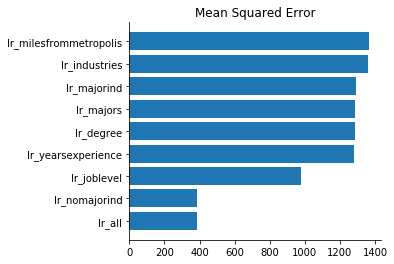

In [12]:
# Graph mean squared errors to compare results for different feature combinations

feature_comp = compare(feature_compare)
feature_comp.graph_results('Mean_Squared_Error', 'features')

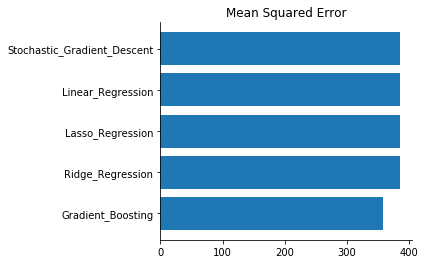

In [13]:
# Graph mean squared errors to compare results for different algorithms

algorithm_comp = compare(algorithm_compare)
algorithm_comp.graph_results('Mean_Squared_Error', 'algorithms')

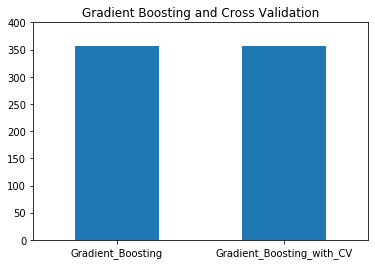

In [14]:
gb_score = algorithm_compare.loc['Gradient_Boosting', 'Mean_Squared_Error']
cv_compare = pd.DataFrame(data=[gb_score,gb.cv_score], index=['Gradient_Boosting','Gradient_Boosting_with_CV'], columns=['Mean_Squared_Error'])
cv_compare.plot.bar(rot=0, legend=False, title='Gradient Boosting and Cross Validation', ylim=(0,400))

plt.savefig('charts/cv_comparison.jpg')

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [15]:
# Process test data

# Instantiate an object for the process_data class (defined above) for the test data
test_data = process_data(test_features)


# Engineer the features for the test data using the same steps as for the training data (see above)
test_data.label_encode('jobType', 'jobLevel', job_levels)

test_data.label_encode('degree', 'degreeLevel', degree_levels)

test_data.transform('major', 'majorInd', training_data.convert_to_bool)

test_data.one_hot_encode('major')

test_data.drop_columns('major_NONE')

test_data.one_hot_encode('industry', drop_first=True)

test_data.normalize('yearsExperience', 'yearsExperience_norm')

test_data.normalize('milesFromMetropolis', 'milesFromMetropolis_norm')

test_data.drop_columns(old_columns)


# Initialize the production model, fit it to the training data, and make predictions on the test data
gb_final = model(GB_reg, training_data.data, features9_all, 'salary')

prod_results = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Mean_Squared_Error'])
gb_final.build_model('Production_Model', compare_df=prod_results)

test_salaries = gb_final.predict(test_data.data)

### ---- 12 Deploy solution ----

In [16]:
# Save predictions to file

pd.DataFrame(test_salaries).to_csv('data/test_salaries.csv')